#Try Stock Prediction - NETFLIX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import joblib
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

## 1. Read Data

In [2]:
# stock_data = pd.read_csv('/content/NFLX.csv', index_col='Date')
# stock_data

ticker = 'BNB-USD'
# start_date = '2020-05-20'
# end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = '2020-05-21'
end_date = '2024-05-21'
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-21,16.887243,17.037516,15.791041,16.122381,16.122381,283593221
2020-05-22,16.126387,16.848112,15.980751,16.639593,16.639593,308017283
2020-05-23,16.631491,16.831505,16.358562,16.588194,16.588194,281071630
2020-05-24,16.579742,16.793018,16.081476,16.083439,16.083439,250849075
2020-05-25,16.074583,16.419571,15.958841,16.400908,16.400908,295250983
...,...,...,...,...,...,...
2024-05-16,582.100159,586.436340,565.762329,569.190247,569.190247,1911862000
2024-05-17,569.190247,584.666016,568.836731,581.178345,581.178345,1557134929
2024-05-18,581.178345,581.987183,575.018555,580.481140,580.481140,1358737176


## 2. Plotting Data

### 2.1 Plot High & Low

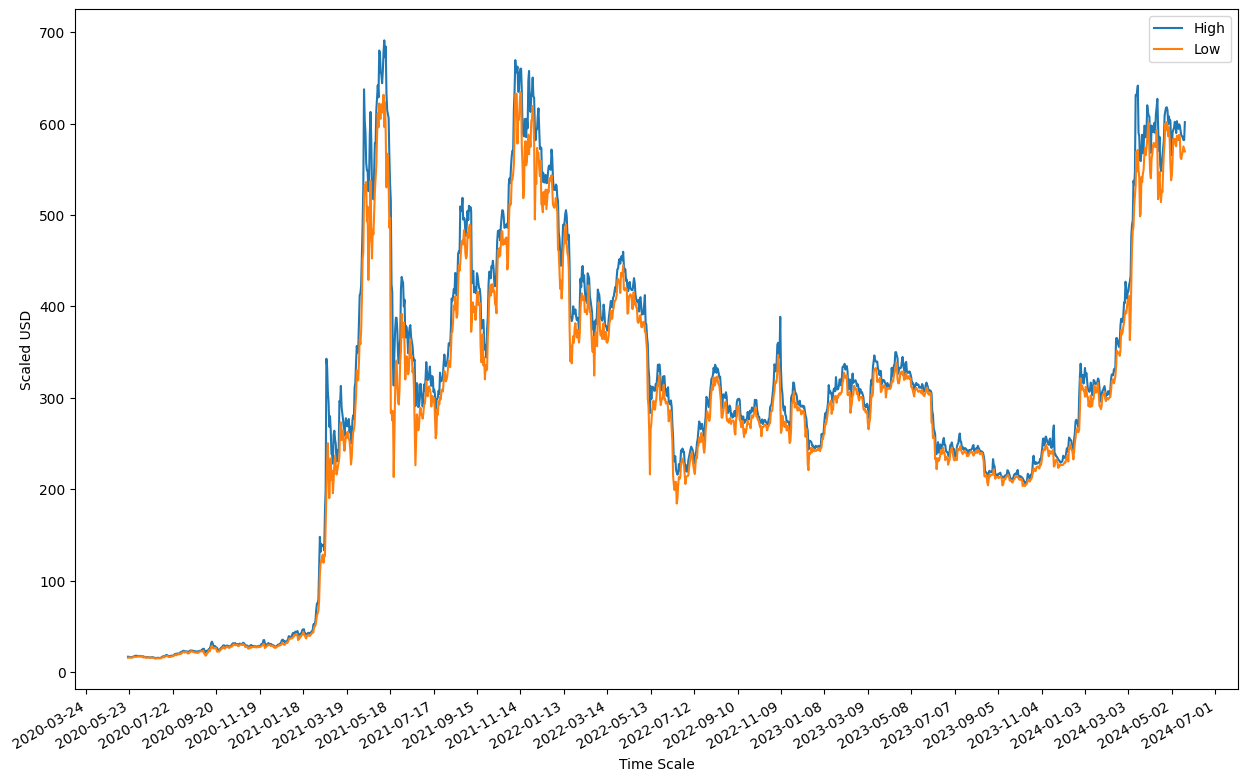

In [3]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
# x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
x_dates = stock_data.index

plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### 2.2 Plot Open & Close

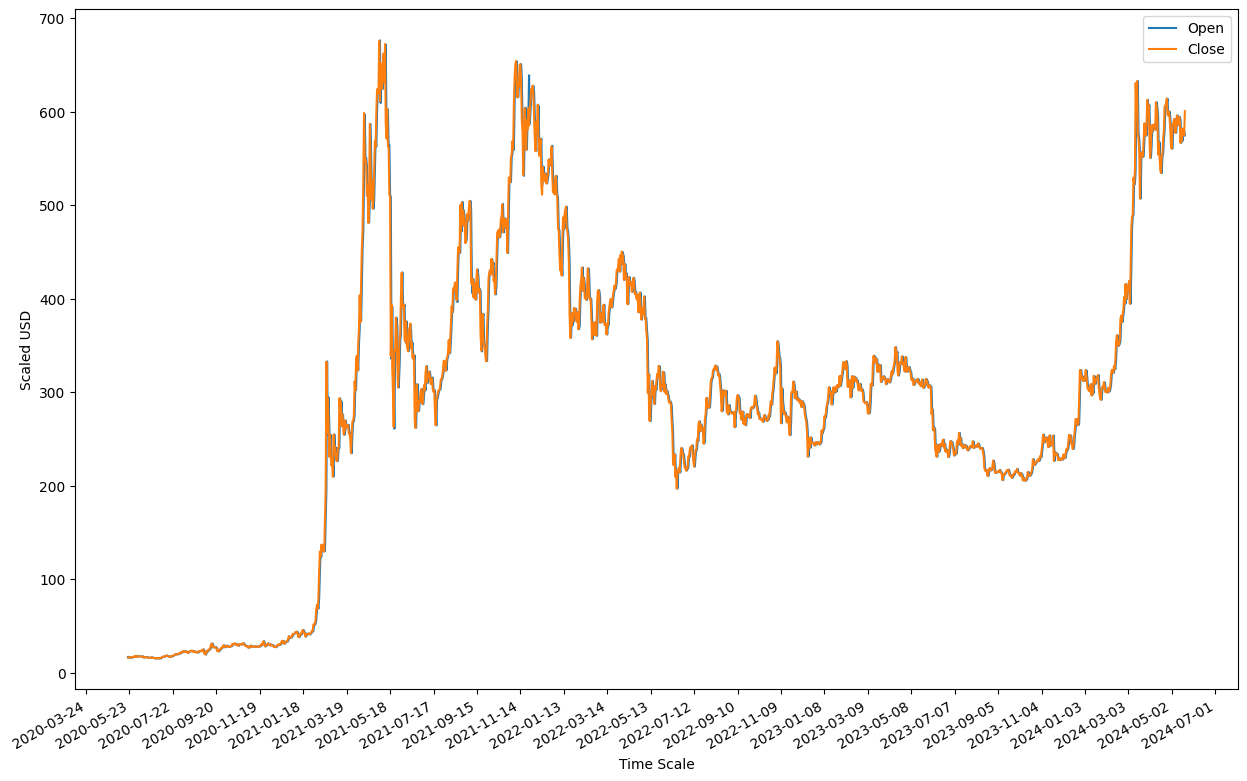

In [4]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
# x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]
x_dates = stock_data.index

plt.plot(x_dates, stock_data['Open'], label='Open')
plt.plot(x_dates, stock_data['Close'], label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## 3. Stock Prediction

### 3.1 Normalize or Rescale

In [5]:
features = stock_data.iloc[:, 0:4]
sc = StandardScaler()
features_scaled = sc.fit_transform(features.values)
stock_data_ft = pd.DataFrame(columns=features.columns, data=features_scaled, index=features.index)

# Simpan objek StandardScaler
joblib.dump(sc, 'standard_scaler.pkl')

['standard_scaler.pkl']

### 3.2 Train & Test

#### 3.2.1 Splitting

In [23]:
def lstm_split(data, n_steps):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [24]:
n_steps = 6
X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[n_steps-1:split_idx + n_steps-1], date_index[split_idx + n_steps-1:len(X1) + n_steps-1]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(1455, 6, 3) (1164, 6, 3) (291, 6, 3) (291,)


#### 3.2.2 Training

In [25]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation="relu"))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 50)             10800     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31051 (121.29 KB)
Trainable params: 31051 (121.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = lstm.fit(X_train, y_train, epochs=205, batch_size=4, verbose=2, shuffle=False)

Epoch 1/205
291/291 - 4s - loss: 0.2570 - 4s/epoch - 12ms/step
Epoch 2/205
291/291 - 1s - loss: 0.0458 - 1s/epoch - 5ms/step
Epoch 3/205
291/291 - 1s - loss: 0.0274 - 1s/epoch - 5ms/step
Epoch 4/205
291/291 - 1s - loss: 0.0241 - 1s/epoch - 5ms/step
Epoch 5/205
291/291 - 1s - loss: 0.0272 - 1s/epoch - 5ms/step
Epoch 6/205
291/291 - 2s - loss: 0.0199 - 2s/epoch - 6ms/step
Epoch 7/205
291/291 - 2s - loss: 0.0169 - 2s/epoch - 8ms/step
Epoch 8/205
291/291 - 2s - loss: 0.0156 - 2s/epoch - 5ms/step
Epoch 9/205
291/291 - 1s - loss: 0.0142 - 1s/epoch - 5ms/step
Epoch 10/205
291/291 - 1s - loss: 0.0126 - 1s/epoch - 5ms/step
Epoch 11/205
291/291 - 1s - loss: 0.0110 - 1s/epoch - 5ms/step
Epoch 12/205
291/291 - 1s - loss: 0.0102 - 1s/epoch - 5ms/step
Epoch 13/205
291/291 - 1s - loss: 0.0097 - 1s/epoch - 5ms/step
Epoch 14/205
291/291 - 1s - loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 15/205
291/291 - 2s - loss: 0.0092 - 2s/epoch - 7ms/step
Epoch 16/205
291/291 - 2s - loss: 0.0095 - 2s/epoch - 6ms/step


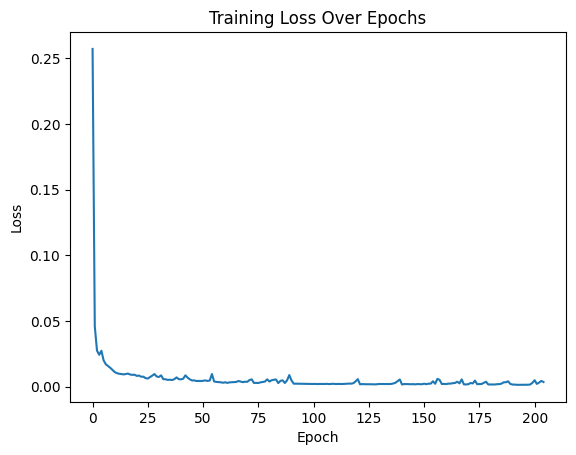

In [27]:
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### 3.2.3 Evaluation

10/10 [==============================] - 0s 3ms/step


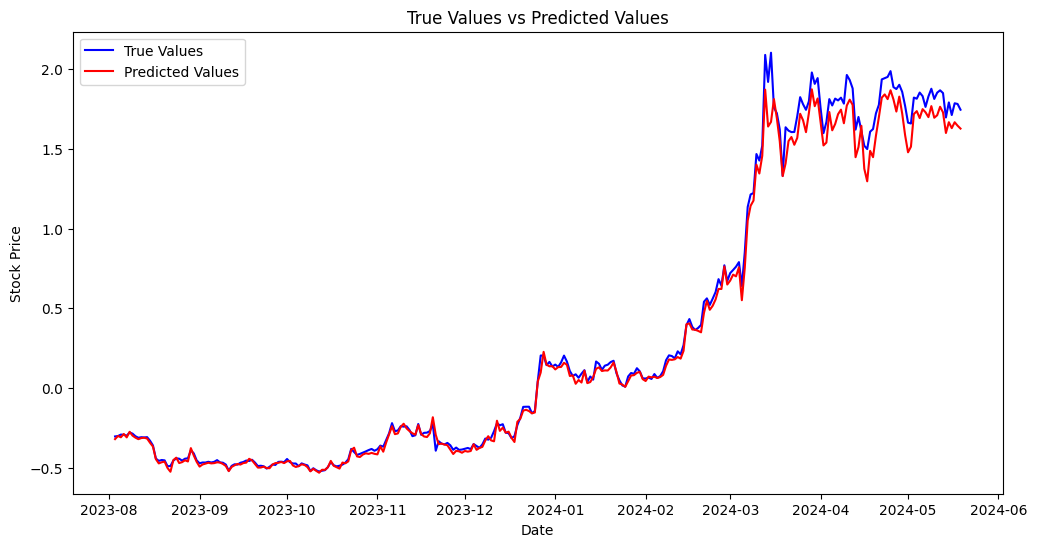

In [28]:
# Make predictions
y_pred = lstm.predict(X_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_test_date, y_test, label='True Values', color='blue')
plt.plot(X_test_date, y_pred, label='Predicted Values', color='red')
plt.title('True Values vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.07061941297651128
MAPE:  0.07482495898367715


In [30]:
# Save Model
lstm.save("predict_nflx.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.2.4 Compare Performance

In [14]:
n_steps_list = [2, 6, 13, 20]
results = []
models = []

for n_steps in n_steps_list:
    X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

    split_idx = int(np.ceil(len(X1) * 0.8))
    X_train, X_test = X1[:split_idx], X1[split_idx:]
    y_train, y_test = y1[:split_idx], y1[split_idx:]

    lstm = Sequential()
    lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
    lstm.add(LSTM(50, activation='relu'))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    lstm.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

    y_pred = lstm.predict(X_test)
    y_pred = y_pred.flatten()  # Ensure y_pred is a 1D array

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append((n_steps, rmse, mape))
    models.append(lstm)

Epoch 1/100
292/292 - 4s - loss: 0.4418 - 4s/epoch - 13ms/step
Epoch 2/100
292/292 - 1s - loss: 0.0162 - 853ms/epoch - 3ms/step
Epoch 3/100
292/292 - 1s - loss: 0.0135 - 919ms/epoch - 3ms/step
Epoch 4/100
292/292 - 1s - loss: 0.0106 - 882ms/epoch - 3ms/step
Epoch 5/100
292/292 - 1s - loss: 0.0094 - 902ms/epoch - 3ms/step
Epoch 6/100
292/292 - 1s - loss: 0.0082 - 887ms/epoch - 3ms/step
Epoch 7/100
292/292 - 1s - loss: 0.0069 - 821ms/epoch - 3ms/step
Epoch 8/100
292/292 - 1s - loss: 0.0068 - 865ms/epoch - 3ms/step
Epoch 9/100
292/292 - 1s - loss: 0.0068 - 861ms/epoch - 3ms/step
Epoch 10/100
292/292 - 1s - loss: 0.0068 - 866ms/epoch - 3ms/step
Epoch 11/100
292/292 - 1s - loss: 0.0065 - 862ms/epoch - 3ms/step
Epoch 12/100
292/292 - 1s - loss: 0.0064 - 1s/epoch - 5ms/step
Epoch 13/100
292/292 - 1s - loss: 0.0056 - 1s/epoch - 5ms/step
Epoch 14/100
292/292 - 1s - loss: 0.0055 - 1s/epoch - 4ms/step
Epoch 15/100
292/292 - 1s - loss: 0.0056 - 952ms/epoch - 3ms/step
Epoch 16/100
292/292 - 1s - lo

In [15]:
for result in results:
    print(f"n_steps: {result[0]}, RMSE: {result[1]}, MAPE: {result[2]}")

n_steps: 2, RMSE: 0.12215869036804144, MAPE: 0.10010175977418173
n_steps: 6, RMSE: 0.05372582201861379, MAPE: 0.06487787154507212
n_steps: 13, RMSE: 0.08267918089227824, MAPE: 0.09383307205931878
n_steps: 20, RMSE: 0.09018409385449735, MAPE: 0.08497624467102646


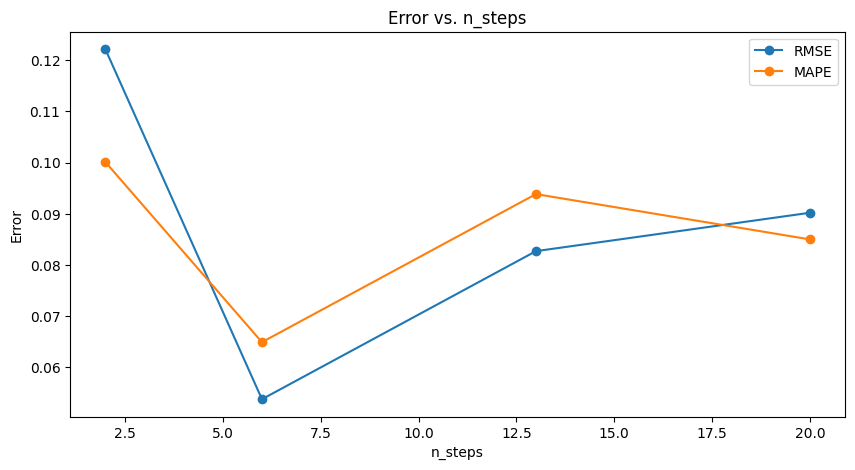

In [16]:
plt.figure(figsize=(10, 5))
plt.plot([result[0] for result in results], [result[1] for result in results], marker='o', label='RMSE')
plt.plot([result[0] for result in results], [result[2] for result in results], marker='o', label='MAPE')
plt.xlabel('n_steps')
plt.ylabel('Error')
plt.title('Error vs. n_steps')
plt.legend()
plt.show()

The result shows that n_steps = n will reach the most accurate prediction, means that predicting the n+1th days is the best choice

#### 3.2.5 Cross Validation

In [17]:
# n_steps = 6
# X1, y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)

In [18]:
# tscv = TimeSeriesSplit(n_splits=5)
# rmse_scores = []
# mape_scores = []

# for train_index, test_index in tscv.split(X1):
#     X_train, X_test = X1[train_index], X1[test_index]
#     y_train, y_test = y1[train_index], y1[test_index]

#     # Define the model
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
#     model.add(LSTM(50, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     # Train the model
#     model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, shuffle=False)

#     # Predict
#     y_pred = model.predict(X_test)
#     y_pred = y_pred[:, 0]

#     # Calculate RMSE and MAPE
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     mape = mean_absolute_percentage_error(y_test, y_pred)

#     rmse_scores.append(rmse)
#     mape_scores.append(mape)

# print(f"Average RMSE: {np.mean(rmse_scores)}, Average MAPE: {np.mean(mape_scores)}")

###3.3 Run Saved Model

In [31]:
# Load the SavedModel
model = load_model('predict_nflx.h5')
sc = joblib.load('standard_scaler.pkl')

In [32]:
def prepare_input_data(ticker, end_date, n_steps):
    stock_data = yf.download(ticker, end=end_date)
    X_feat = stock_data[['Open', 'High', 'Low']]
    target_y = stock_data['Close']

    X_ft = sc.fit_transform(X_feat.values)
    stock_data_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)
    stock_data_ft['Close'] = target_y.values

    input_data = stock_data_ft.values[-n_steps:, :-1]
    input_data = np.expand_dims(input_data, axis=0)

    return input_data, stock_data_ft.index[-1]

In [33]:
# Parameter prediksi
ticker = 'BNB-USD'
end_date = '2024-04-05'
n_steps = 6

# Menyiapkan data input
input_data, last_date = prepare_input_data(ticker, end_date, n_steps)

# Melakukan prediksi
predicted_price_scaled = model.predict(input_data).flatten()[0]

# Mengembalikan hasil prediksi ke skala semula
predicted_price = sc.inverse_transform([[np.nan, predicted_price_scaled, np.nan]])[0][1]

# Menampilkan hasil prediksi
print(f"Harga saham {ticker} yang diprediksi untuk tanggal {end_date} adalah: {predicted_price:.2f}")

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 403ms/step
Harga saham BNB-USD yang diprediksi untuk tanggal 2024-04-05 adalah: 584.73
